# Importing and Installation

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc, roc_curve, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lime import lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bc7bfba09b1194bc022584c6cc93728c17018707160639f2af2c4f7e3d9cc7c9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=d0352e4793da364a24f86a3d56179e498785d56912224e7d8360e90f202794ab
  Stored in directory: /root/.cache/pip/wheels/9f/d8/4e/61a6f4e78fe6700f66b699ab38377f0aa5b33e3ef55751ba38
Successfully built lime scorecardpy


In [ ]:
df = pd.read_csv('/content/cs-training.csv')
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (150000, 12)


Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

# Basic Pre-Processing

In [ ]:
df = df.rename(columns={
    'Unnamed: 0': 'ID',
    'SeriousDlqin2yrs': 'Target',
    'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
    'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
    'DebtRatio': 'DebtRatio',
    'MonthlyIncome': 'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
    'NumberOfTimes90DaysLate': 'Late90',
    'NumberRealEstateLoansOrLines': 'PropLines',
    'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
    'NumberOfDependents': 'Deps'
})

df = df.drop(columns=['ID'])
print("Initial shape:", df.shape)


Initial shape: (150000, 11)


# **EDA**

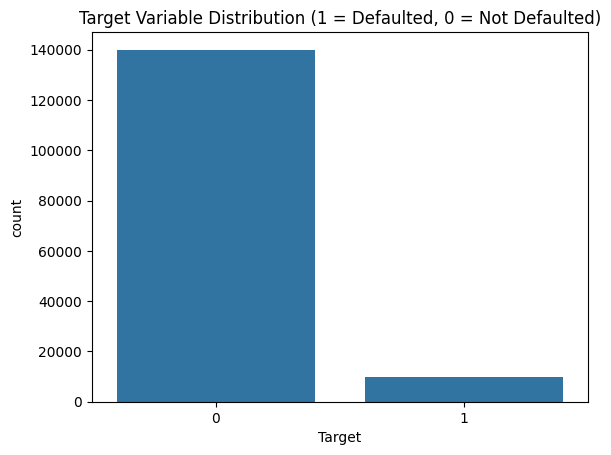

Target
0    0.93316
1    0.06684
Name: proportion, dtype: float64

In [ ]:
sns.countplot(x='Target', data=df)
plt.title('Target Variable Distribution (1 = Defaulted, 0 = Not Defaulted)')
plt.show()

df['Target'].value_counts(normalize=True)

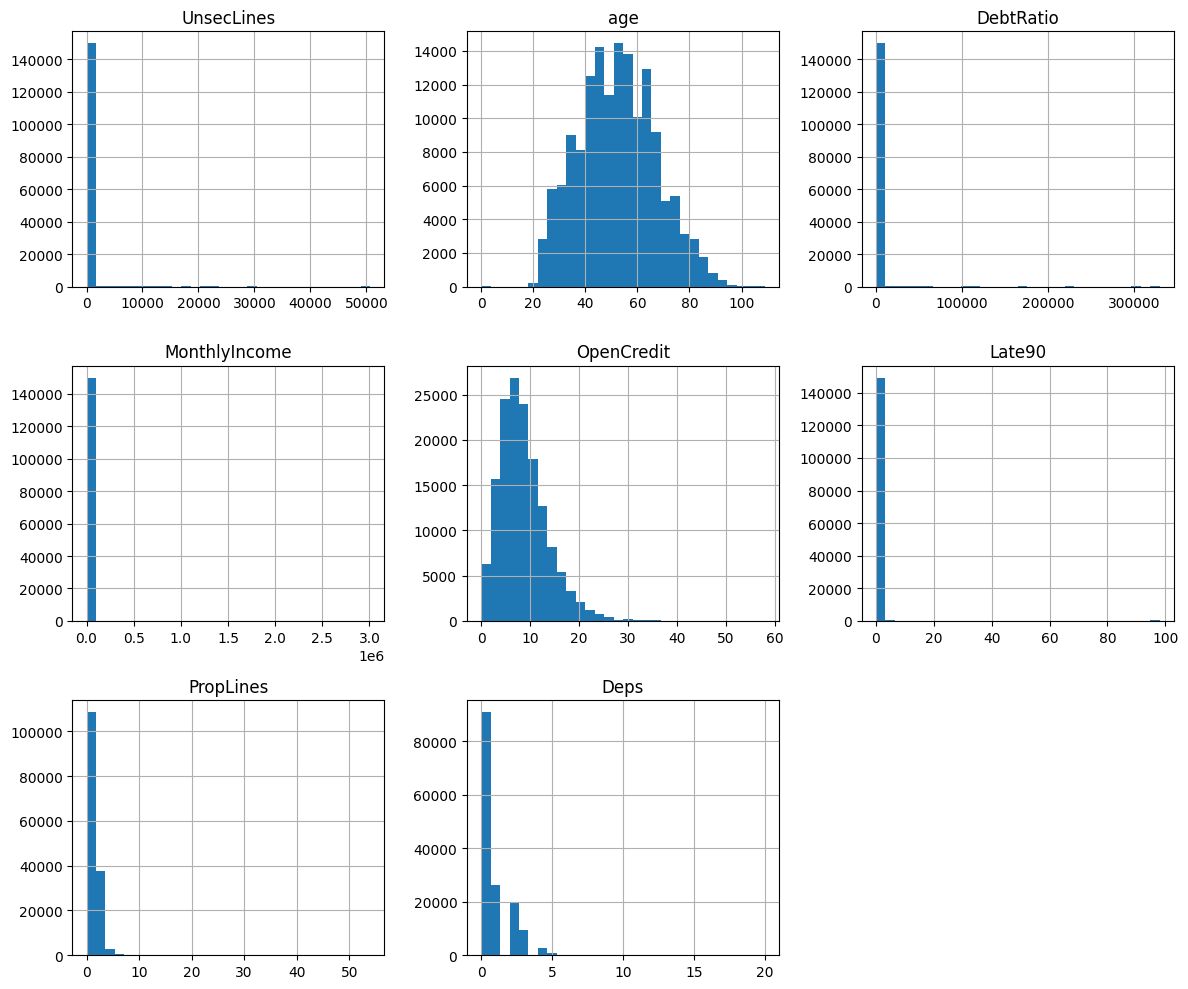

In [ ]:
#Feature level exploration
num_cols = ['UnsecLines', 'age', 'DebtRatio',
             'MonthlyIncome', 'OpenCredit',
             'Late90', 'PropLines',
             'Deps', ]

df[num_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

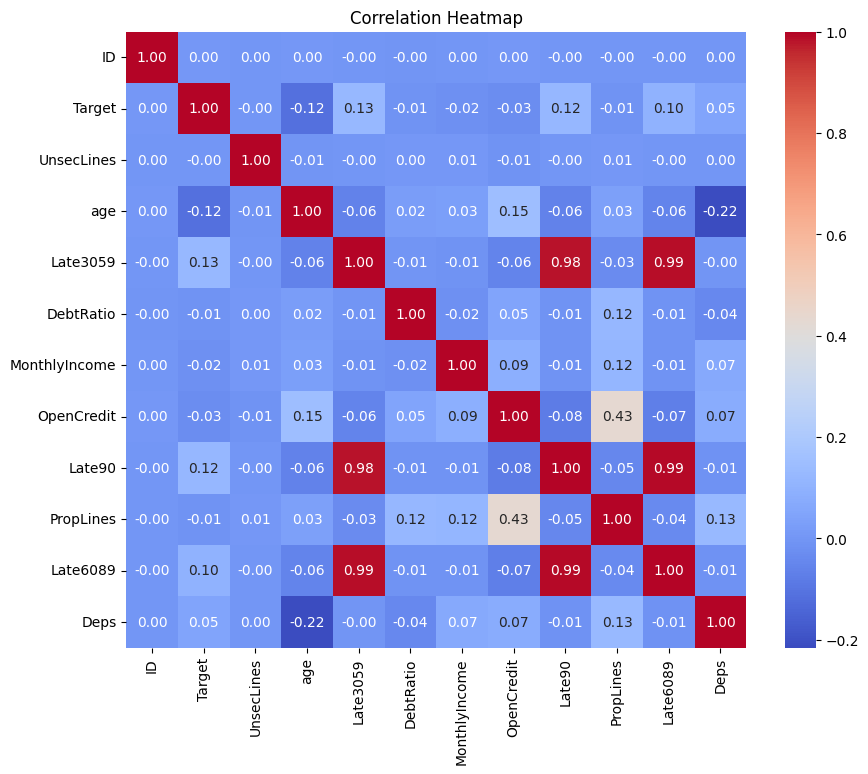

Target           1.000000
Late3059         0.125587
Late90           0.117175
Late6089         0.102261
Deps             0.046869
ID               0.002801
UnsecLines      -0.001802
PropLines       -0.007038
DebtRatio       -0.007602
MonthlyIncome   -0.017151
OpenCredit      -0.029669
age             -0.115386
Name: Target, dtype: float64

In [ ]:
# correlation matrix
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# specifically see correlation of features with Target
corr['Target'].sort_values(ascending=False)

In [ ]:
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

Missing values per column:
 ID                   0
Target               0
UnsecLines           0
age                  0
Late3059             0
DebtRatio            0
MonthlyIncome    29731
OpenCredit           0
Late90               0
PropLines            0
Late6089             0
Deps              3924
dtype: int64


# Pre-Procesing

In [ ]:
#splitting the data first to prevent data leakage form train set to test set
X = df.drop(columns=['Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (120000, 10)
X_test: (30000, 10)
y_train: (120000,)
y_test: (30000,)


In [ ]:
# MEDIAN for MonthlyIncome
median_income = X_train['MonthlyIncome'].median()

# MODE for Dependents
mode_deps = X_train['Deps'].mode()[0]

# Apply to train
X_train['MonthlyIncome'] = X_train['MonthlyIncome'].fillna(median_income)
X_train['Deps'] = X_train['Deps'].fillna(mode_deps)

# Apply same values to test
X_test['MonthlyIncome'] = X_test['MonthlyIncome'].fillna(median_income)
X_test['Deps'] = X_test['Deps'].fillna(mode_deps)


In [ ]:
#capping instead of IQR, at 10 for count features
for col in ['Late3059', 'Late90', 'Late6089', 'Deps']:
    X_train[col] = X_train[col].clip(upper=10)
    X_test[col] = X_test[col].clip(upper=10)

cap_cols = ['MonthlyIncome', 'DebtRatio', 'UnsecLines']
cap_values = {}

#99.5 for numerical values
for col in cap_cols:
    cap_values[col] = X_train[col].quantile(0.995)
    X_train[col] = X_train[col].clip(upper=cap_values[col])
    X_test[col] = X_test[col].clip(upper=cap_values[col])

In [ ]:
#Applyig log(1+x) to treat skewed features
for col in ['MonthlyIncome', 'DebtRatio', 'UnsecLines']:
    X_train[col + '_log'] = np.log1p(X_train[col])
    X_test[col + '_log'] = np.log1p(X_test[col])

# Drop original skewed columns from both sets
X_train = X_train.drop(columns=['MonthlyIncome', 'DebtRatio', 'UnsecLines'])
X_test = X_test.drop(columns=['MonthlyIncome', 'DebtRatio', 'UnsecLines'])


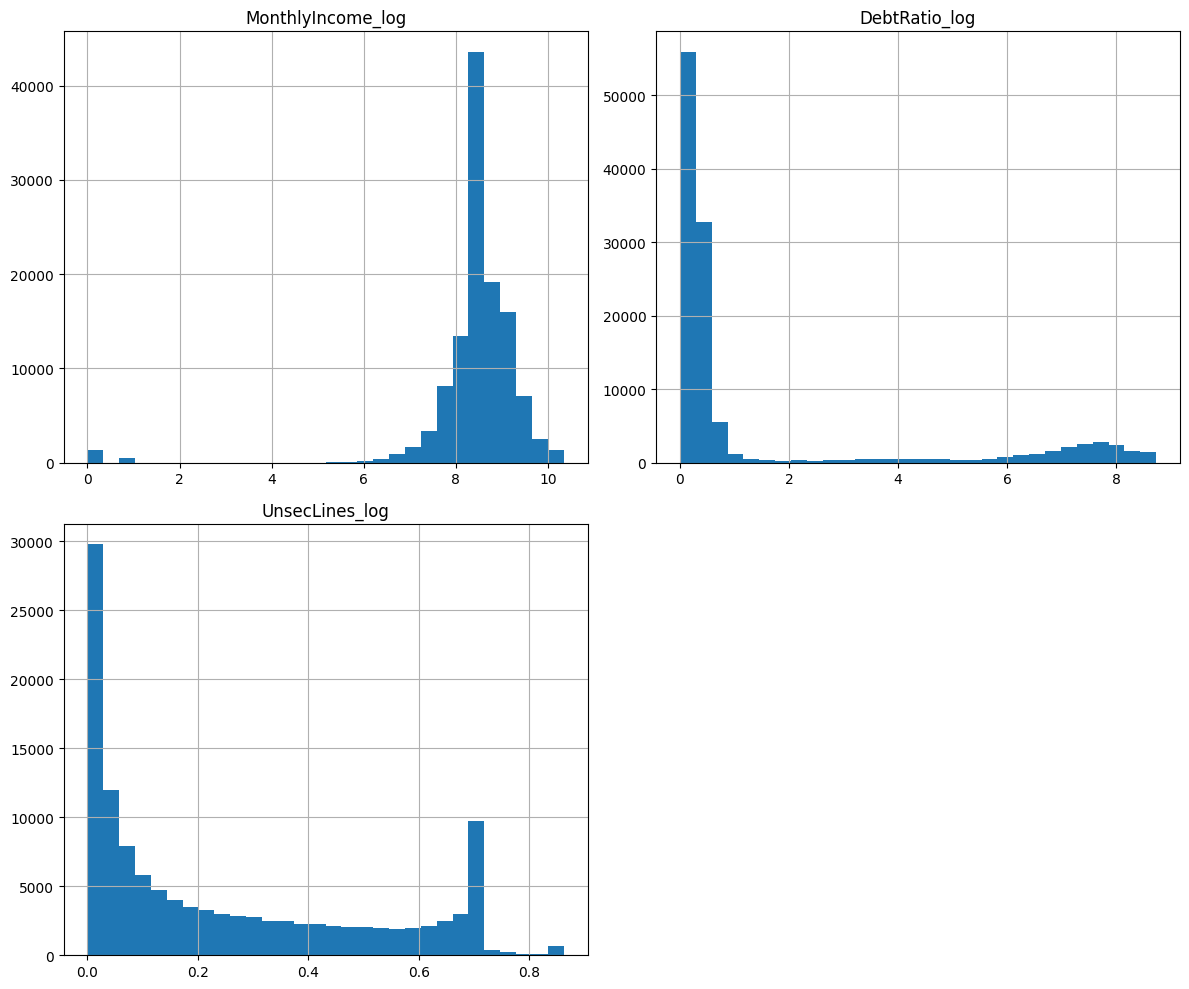

In [ ]:
num_cols = ['MonthlyIncome_log', 'DebtRatio_log', 'UnsecLines_log']

X_train[num_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

Monthly income now looks good, but debt ratio and unseclines are now bimodal, which isnt really good for linear regression, hence will try diferent method for it

In [ ]:
X_train.head()

age  Late3059  OpenCredit  Late90  PropLines  Late6089  Deps  \
57836    62         0           5       0          1         0   2.0   
132895   73         0           6       0          1         0   0.0   
27981    32         0           8       0          0         0   2.0   
37852    60         0           5       0          0         0   0.0   
103813   60         0          10       0          1         0   0.0   

        MonthlyIncome_log  DebtRatio_log  UnsecLines_log  
57836            8.592486       7.518607        0.108843  
132895           8.243019       0.404500        0.008668  
27981            8.220672       0.192271        0.194334  
37852            8.592486       4.779123        0.693147  
103813           8.006701       0.701774        0.207415

In [ ]:
#scaling the data for logistic reg
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train_scaled.head()


age  Late3059  OpenCredit    Late90  PropLines  Late6089  \
57836   0.657506 -0.325458   -0.671428 -0.170483  -0.016033 -0.155256   
132895  1.402198 -0.325458   -0.477692 -0.170483  -0.016033 -0.155256   
27981  -1.373472 -0.325458   -0.090221 -0.170483  -0.898607 -0.155256   
37852   0.522107 -0.325458   -0.671428 -0.170483  -0.898607 -0.155256   
103813  0.522107 -0.325458    0.297250 -0.170483  -0.016033 -0.155256   

            Deps  MonthlyIncome_log  DebtRatio_log  UnsecLines_log  
57836   1.141540           0.126496       2.290682       -0.552423  
132895 -0.666816          -0.165524      -0.425548       -0.955209  
27981   1.141540          -0.184198      -0.506579       -0.208681  
37852  -0.666816           0.126496       1.244722        1.796954  
103813 -0.666816          -0.362996      -0.312046       -0.156084

# Logistic Regression

In [ ]:
model_lr = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# 2. Train the model on the scaled training data
model_lr.fit(X_train_scaled, y_train)

# 3. Predict probabilities on the test set
# For credit risk, we always look at the probability of the positive class (index 1)
y_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

# 4. Predict class labels using the default threshold (0.5)
y_pred_default_thresh = model_lr.predict(X_test_scaled)

#Evaluate the baseline metrics
auc_score = roc_auc_score(y_test, y_proba_lr)
f1_score_default = f1_score(y_test, y_pred_default_thresh)
gini = 2 * auc_score - 1
print(f"AUC Score: {auc_score:.4f}")
print(f"F1 Score(Default Threshold): {f1_score_default:.4f}")
print("-" * 30)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_default_thresh))
print("-" * 30)
print("Classification Report:\n")
print(classification_report(y_test, y_pred_default_thresh, zero_division=0))

AUC Score: 0.8578
GINI: 0.7156
F1 Score(Default Threshold): 0.3287
------------------------------
Confusion Matrix:
[[22277  5718]
 [  486  1519]]
------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27995
           1       0.21      0.76      0.33      2005

    accuracy                           0.79     30000
   macro avg       0.59      0.78      0.60     30000
weighted avg       0.93      0.79      0.84     30000



/tmp/ipython-input-2092341275.py:7: RuntimeWarning: invalid value encountered in divide
  fscores_lr = 2 * (precision_lr[:-1] * recall_lr[:-1]) / (precision_lr[:-1] + recall_lr[:-1])


 Logistic Regression Optimal F1 Score: 0.4436
 Logistic Regression Threshold: 0.7090


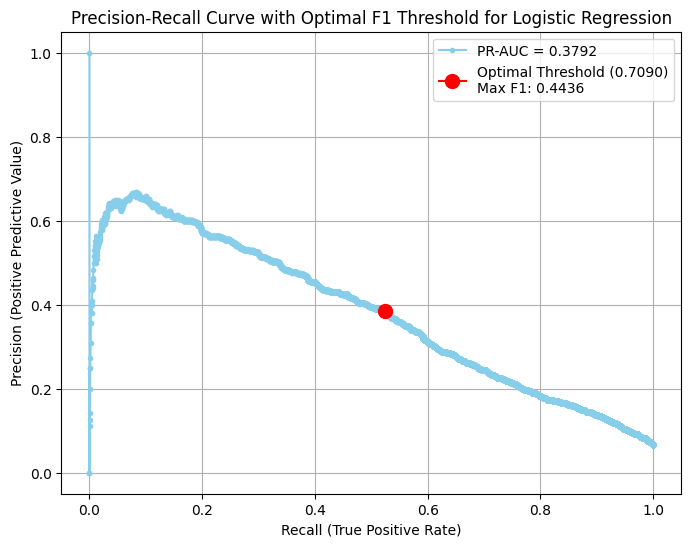

In [ ]:
# y_proba_lr is the array of probabilities generated for logistic regression model
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_proba_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

# --- 2. Find the Optimal F1 Score and Threshold ---
# Exclude the last point to avoid unstable F1 calculation
fscores_lr = 2 * (precision_lr[:-1] * recall_lr[:-1]) / (precision_lr[:-1] + recall_lr[:-1])
fscores_lr = np.nan_to_num(fscores_lr, nan=0.0, posinf=0.0, neginf=0.0)

# Find the index of the maximum F1 Score
ix_lr = np.argmax(fscores_lr)
best_f1_lr = fscores_lr[ix_lr]
best_threshold_lr = thresholds_lr[ix_lr]
optimal_recall_lr = recall_lr[ix_lr]
optimal_precision_lr = precision_lr[ix_lr]

# --- 5. Print Optimal F1 and Threshold ---
print(f" Logistic Regression Optimal F1 Score: {best_f1_lr:.4f}")
print(f" Logistic Regression Threshold: {best_threshold_lr:.4f}")

# --- 3. Plot the Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, marker='.', color='skyblue',
         label=f'PR-AUC = {pr_auc_lr:.4f}')

# Mark the Optimal Threshold Point
plt.plot(optimal_recall_lr, optimal_precision_lr, marker='o', markersize=10, color='red',
         label=f'Optimal Threshold ({best_threshold_lr:.4f})\nMax F1: {best_f1_lr:.4f}')

# Set Labels and Title
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve with Optimal F1 Threshold for Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()


             Feature  Coefficient  Abs_Coefficient  Odds_Ratio
9     UnsecLines_log     0.751091         0.751091    2.119312
3             Late90     0.567969         0.567969    1.764679
1           Late3059     0.439535         0.439535    1.551985
5           Late6089     0.401364         0.401364    1.493862
0                age    -0.273803         0.273803    0.760482
2         OpenCredit     0.145339         0.145339    1.156432
4          PropLines     0.120525         0.120525    1.128089
8      DebtRatio_log    -0.068843         0.068843    0.933474
7  MonthlyIncome_log    -0.049562         0.049562    0.951647
6               Deps     0.011064         0.011064    1.011126


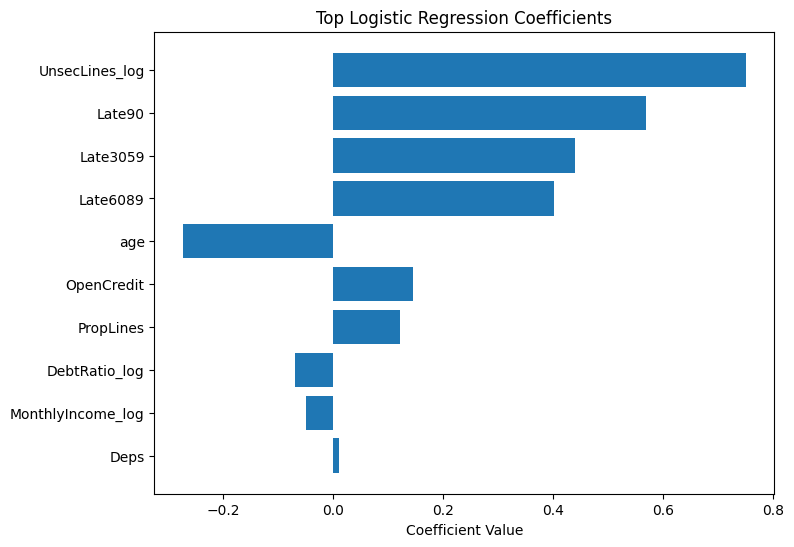

In [ ]:
# Get feature names and coefficients
feature_names = X_train_scaled.columns
coefficients = model_lr.coef_[0]

# Create DataFrame for easy viewing
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Add odds ratio for interpretability
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Display top features
print(coef_df.head(15))
#plot
top_features = coef_df.head(15)
plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()


# XGBOOST

In [ ]:
from xgboost import XGBClassifier

# 1. Calculate the Imbalance Ratio
# This tells XGBoost how much more important the positive class (1/Default) is.
count_neg = y_train.value_counts()[0]
count_pos = y_train.value_counts()[1]
scale_pos_weight = count_neg / count_pos
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# 2. Initialize the XGBoost Classifier
model_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_estimators=150,
    learning_rate=0.1,
    scale_pos_weight = scale_pos_weight,
)

# 3. Train the Model
model_xgb.fit(X_train_scaled, y_train)

# 4. Predict Probabilities and Labels on the Test Set
y_proba_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb_default = model_xgb.predict(X_test_scaled)

# 5. Evaluate the Baseline Metrics
auc_score_xgb = roc_auc_score(y_test, y_proba_xgb)
f1_score_xgb_default = f1_score(y_test, y_pred_xgb_default)

print("\n--- XGBoost Baseline Model Summary ---")
print(f"AUC Score: {auc_score_xgb:.4f}")
print(f"F1 Score(Default Threshold): {f1_score_xgb_default:.4f}")
print("-" * 50)
print("Classification Report (0.5 Threshold):\n", classification_report(y_test, y_pred_xgb_default, zero_division=0))

Calculated scale_pos_weight: 13.96


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:49:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Baseline Model Summary ---
AUC Score: 0.8644
F1 Score(Default Threshold): 0.3483
--------------------------------------------------
Classification Report (0.5 Threshold):
               precision    recall  f1-score   support

           0       0.98      0.81      0.89     27995
           1       0.23      0.76      0.35      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.79      0.62     30000
weighted avg       0.93      0.81      0.85     30000



Optimal F1 Score @ optimal threshold: 0.4453
Optimal Threshold : 0.7619
Optimal F2 Score @ optimal threshold: 0.5229
Optimal F2 Threshold : 0.5933


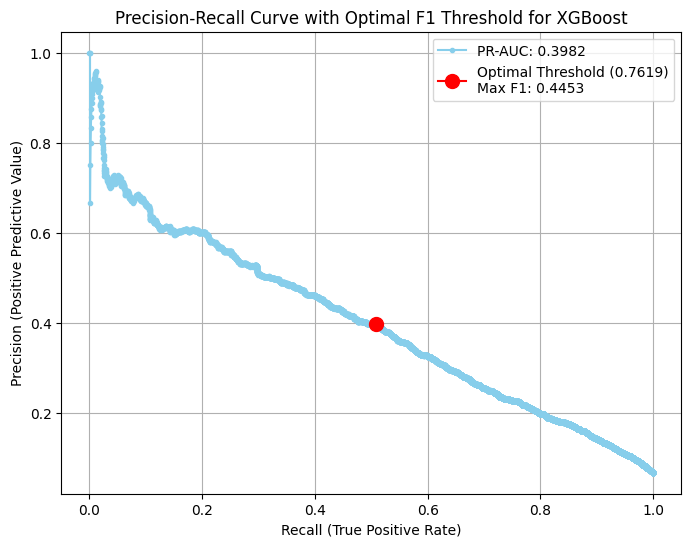

In [ ]:
# y_proba_xgb is the array of probabilities generated from your XGBoost model
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

# 2. Find the Optimal F1 Score and Threshold
# Note: We exclude the last point of precision/recall which corresponds to
# a threshold of 1.0 (where the F1 calculation is unstable or 0/0).
fscores_xgb = 2 * (precision_xgb[:-1] * recall_xgb[:-1]) / (precision_xgb[:-1] + recall_xgb[:-1])
fscores_xgb = np.nan_to_num(fscores_xgb, nan=0.0, posinf=0.0, neginf=0.0)

# Find the index of the maximum F1 Score
ix_xgb = np.argmax(fscores_xgb)
best_f1_xgb = fscores_xgb[ix_xgb]
best_threshold_xgb = thresholds_xgb[ix_xgb]
optimal_recall_xgb = recall_xgb[ix_xgb]
optimal_precision_xgb = precision_xgb[ix_xgb]

print(f"Optimal F1 Score @ optimal threshold: {best_f1_xgb:.4f}")
print(f"Optimal Threshold : {best_threshold_xgb:.4f}")

# ---- F2 SCORE CALCULATION----
beta = 2
f2scores_xgb = (1 + beta**2) * (precision_xgb[:-1] * recall_xgb[:-1]) / \
               (beta**2 * precision_xgb[:-1] + recall_xgb[:-1])
f2scores_xgb = np.nan_to_num(f2scores_xgb, nan=0.0, posinf=0.0, neginf=0.0)

# Find optimal F2 score and threshold
ix_f2 = np.argmax(f2scores_xgb)
best_f2_xgb = f2scores_xgb[ix_f2]
best_f2_threshold_xgb = thresholds_xgb[ix_f2]

print(f"Optimal F2 Score @ optimal threshold: {best_f2_xgb:.4f}")
print(f"Optimal F2 Threshold : {best_f2_threshold_xgb:.4f}")

# --- 3. Plot the Precision-Recall Curve ---
plt.figure(figsize=(8, 6))

# Plot the PR Curve
plt.plot(recall_xgb, precision_xgb, marker='.',
         label=f'PR-AUC: {pr_auc_xgb:.4f}',
         color='skyblue')

# Mark the Optimal Threshold Point
plt.plot(optimal_recall_xgb, optimal_precision_xgb, marker='o',
         markersize=10, color='red',
         label=f'Optimal Threshold ({best_threshold_xgb:.4f})\nMax F1: {best_f1_xgb:.4f}')

# Set Labels and Title
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve with Optimal F1 Threshold for XGBoost')
plt.grid(True)
plt.legend()
plt.show()

# Random Forest

In [ ]:
# 1. Initialize the Random Forest
model_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    n_jobs=-1
)

# 2. Train the model
model_rf.fit(X_train_scaled, y_train)

# 3. Predict using default threshold (0.5)
y_pred_rf_default = model_rf.predict(X_test_scaled)

# 4. Evaluate
auc_score_rf = roc_auc_score(y_test, model_rf.predict_proba(X_test_scaled)[:, 1])
f1_positive = f1_score(y_test, y_pred_rf_default, pos_label=1)

print("\n--- Random Forest Model Summary (Default Threshold 0.5) ---")
print(f"AUC Score: {auc_score_rf:.4f}")
print(f"F1 Score: {f1_positive:.4f}")
print("-" * 50)
print("Classification Report:\n", classification_report(y_test, y_pred_rf_default, zero_division=0))



--- Random Forest Model Summary (Default Threshold 0.5) ---
AUC Score: 0.8628
F1 Score: 0.3526
--------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90     27995
           1       0.23      0.73      0.35      2005

    accuracy                           0.82     30000
   macro avg       0.60      0.78      0.62     30000
weighted avg       0.93      0.82      0.86     30000



 Random Forest Optimal F1 Score: 0.4283
 Random Forest Optimal Threshold: 0.6673


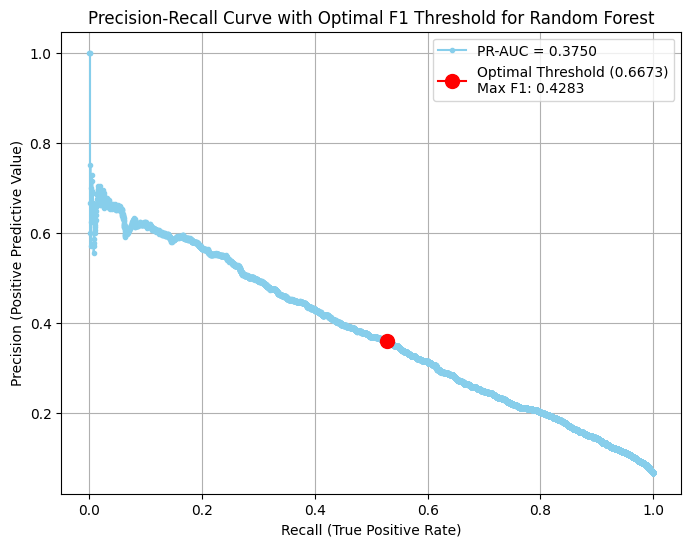

In [ ]:
# y_proba_rf is the array of probabilities from your Random Forest model
y_proba_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

# --- 2. Calculate Precision, Recall, and PR AUC ---
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

# --- 3. Find the Optimal F1 Score and Threshold ---
# Exclude last point corresponding to threshold=1.0
fscores_rf = 2 * (precision_rf[:-1] * recall_rf[:-1]) / (precision_rf[:-1] + recall_rf[:-1])
fscores_rf = np.nan_to_num(fscores_rf, nan=0.0, posinf=0.0, neginf=0.0)

# Index of maximum F1 score
ix_rf = np.argmax(fscores_rf)
best_f1_rf = fscores_rf[ix_rf]
best_threshold_rf = thresholds_rf[ix_rf]
optimal_recall_rf = recall_rf[ix_rf]
optimal_precision_rf = precision_rf[ix_rf]

# --- 5. Print Optimal F1 and Threshold ---
print(f" Random Forest Optimal F1 Score: {best_f1_rf:.4f}")
print(f" Random Forest Optimal Threshold: {best_threshold_rf:.4f}")

# --- 4. Plot the Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, marker='.',
         label=f'PR-AUC = {pr_auc_rf:.4f}',
         color='skyblue')

# Mark Optimal Threshold Point
plt.plot(optimal_recall_rf, optimal_precision_rf, marker='o',
         markersize=10, color='red',
         label=f'Optimal Threshold ({best_threshold_rf:.4f})\nMax F1: {best_f1_rf:.4f}')

# Labels and Title
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve with Optimal F1 Threshold for Random Forest')
plt.grid(True)
plt.legend()
plt.show()


# Summary

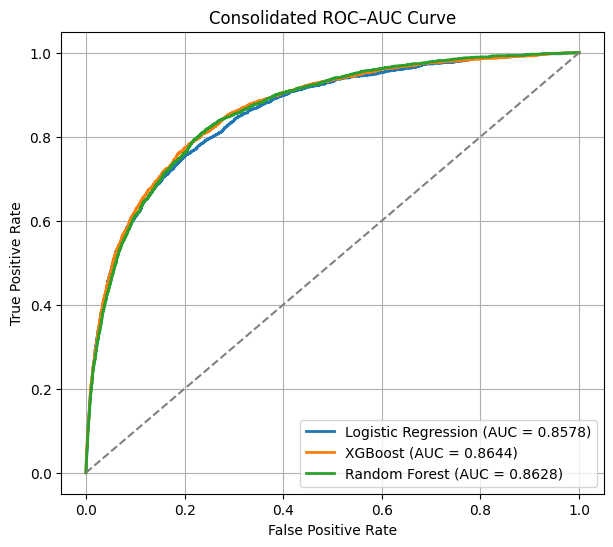

In [ ]:
# ROC data for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Plot all curves together
plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Consolidated ROC–AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



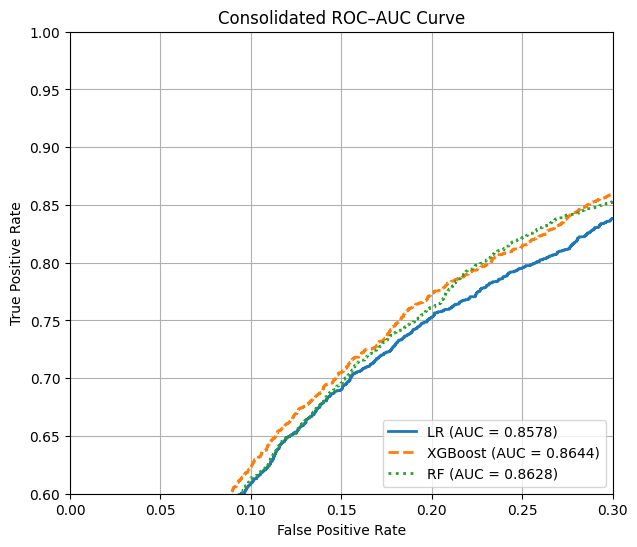

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, lw=2, linestyle='-', label=f'LR (AUC = {auc_lr:.4f})')
plt.plot(fpr_xgb, tpr_xgb, lw=2, linestyle='--', label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot(fpr_rf, tpr_rf, lw=2, linestyle=':', label=f'RF (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Consolidated ROC–AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlim(0, 0.3)  # zoom in horizontally
plt.ylim(0.6, 1.0)  # zoom in vertically
plt.show()


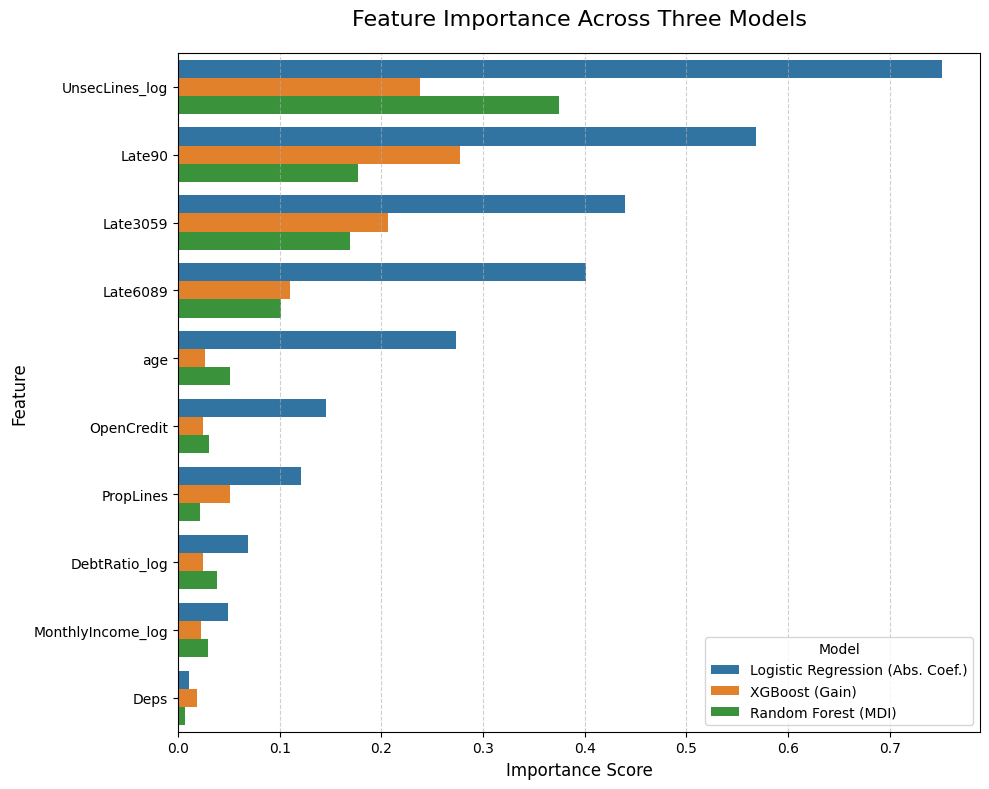

In [ ]:
import seaborn as sns

features = X_train.columns

# Create initial DataFrames
df_lr = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(model_lr.coef_[0]),
    'Model': 'Logistic Regression (Abs. Coef.)'
})

df_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': model_xgb.feature_importances_,
    'Model': 'XGBoost (Gain)'
})

df_rf = pd.DataFrame({
    'Feature': features,
    'Importance': model_rf.feature_importances_,
    'Model': 'Random Forest (MDI)'
})

#Step 2: Consolidate and Sort Data
df_consolidated = pd.concat([df_lr, df_xgb, df_rf], ignore_index=True)

# Sort features by their average importance across all models
feature_order = (
    df_consolidated
    .groupby('Feature')['Importance']
    .mean()
    .sort_values(ascending=False)
    .index
)
df_consolidated['Feature'] = pd.Categorical(
    df_consolidated['Feature'],
    categories=feature_order,
    ordered=True
)

# Step 3: Generate the Consolidated Plot
plt.figure(figsize=(10, 8))

sns.barplot(
    x='Importance',
    y='Feature',
    hue='Model',
    data=df_consolidated,
    palette=['#1f77b4', '#ff7f0e', '#2ca02c'],
    errorbar=None
)

plt.title('Feature Importance Across Three Models', fontsize=16, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Model', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# SHAP and LIME

ExactExplainer explainer: 1501it [12:54,  1.92it/s]


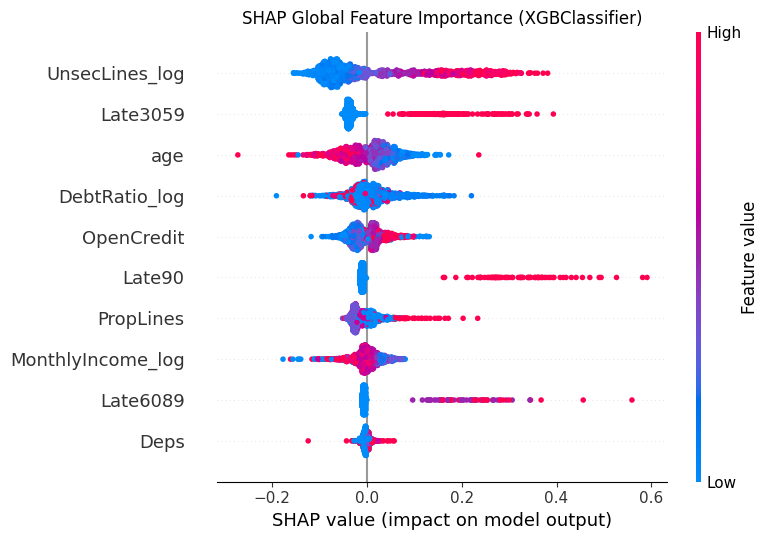

In [ ]:
# Convert scaled test data to DataFrame
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_sample = X_test_df.sample(n=1500, random_state=42)

# Wrap your XGBClassifier in a callable returning probabilities for the positive class
model_callable = lambda X: model_xgb.predict_proba(X)[:, 1]

explainer = shap.Explainer(model_callable, X_sample)
shap_values_xgb = explainer(X_sample)

# Plot global feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_xgb.values,  # numeric SHAP values
    features=X_sample,
    plot_type="dot",
    show=False
)
plt.title("SHAP Global Feature Importance (XGBClassifier)")
plt.tight_layout()
plt.show()


ExactExplainer explainer: 1001it [07:44,  2.12it/s]


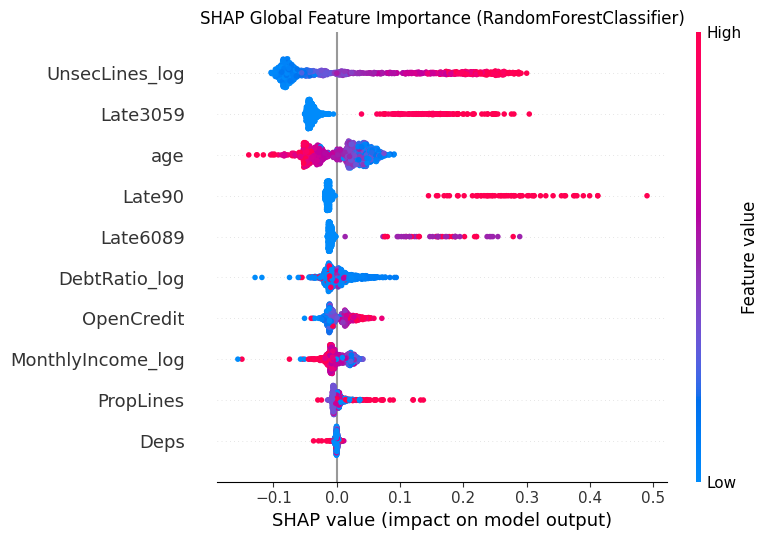

In [ ]:
#SHAP for randomforest
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_sample_rf = X_test_df.sample(n=1000, random_state=42)

model_callable_rf = lambda X: model_rf.predict_proba(X)[:, 1]
explainer_rf = shap.Explainer(model_callable_rf, X_sample_rf)
shap_values_rf = explainer_rf(X_sample_rf)

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_rf.values,
    X_sample_rf,
    plot_type="dot",
    show=False
)
plt.title("SHAP Global Feature Importance (RandomForestClassifier)")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import spearmanr

# Mean absolute SHAP importance for both models
shap_importance_xgb = np.abs(shap_values_xgb.values).mean(axis=0)
shap_importance_rf = np.abs(shap_values_rf.values).mean(axis=0)

# Combine into one DataFrame
df_shap = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'XGB': shap_importance_xgb,
    'RF': shap_importance_rf
}).set_index('Feature')

# Rank correlation
corr, _ = spearmanr(df_shap['XGB'], df_shap['RF'])
print(f"Spearman Rank Correlation (SHAP Consistency): {corr:.3f}")


Spearman Rank Correlation (SHAP Consistency): 0.806


<Figure size 1000x600 with 0 Axes>

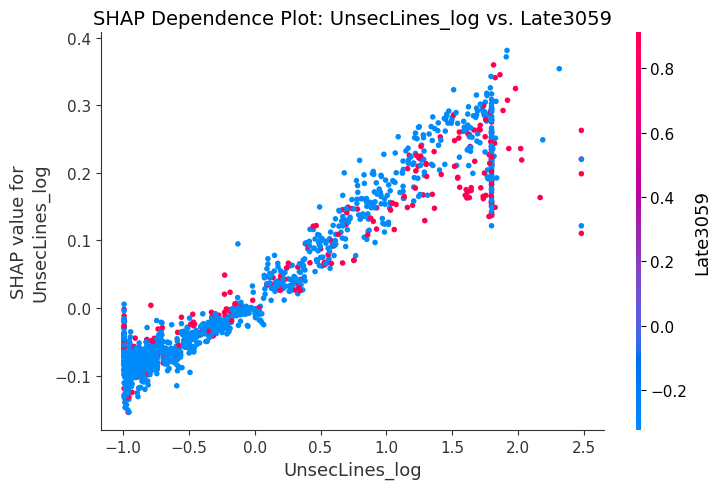

In [ ]:
# 1. Define the features to plot
main_feature = 'UnsecLines_log'
interaction_feature = 'Late3059'

# 2. Generate the Dependence Plot using the same data used for SHAP
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    ind=main_feature,
    shap_values=shap_values_xgb.values,
    features=X_sample,                     # use the exact dataframe the explainer saw
    interaction_index=interaction_feature,
    show=False
)

plt.title(f'SHAP Dependence Plot: {main_feature} vs. {interaction_feature}', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from lime import lime_tabular

# Predictions using tuned threshold
y_pred_xgb = (y_proba_xgb >= best_threshold_xgb).astype(int)
y_pred_series_xgb = pd.Series(y_pred_xgb, index=y_test.index)

# True Positive (Actual 1, Predicted 1)
tp_index = y_test[(y_test == 1) & (y_pred_series_xgb == 1)].index[0]
instance_to_explain = X_test_scaled.loc[tp_index]
true_label = y_test.loc[tp_index]

print("\n--- LIME Target Customer Found (XGB True Positive) ---")
print(f"Index: {tp_index}, True Label: {true_label}")

explainer_xgb = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    class_names=['No Default (0)', 'Default (1)'],
    mode='classification',
    kernel_width=0.75,
    random_state=42
)

predict_fn_xgb = lambda x: model_xgb.predict_proba(x)

exp_xgb_tp = explainer_xgb.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=predict_fn_xgb,
    num_features=8
)

print("\n--- LIME Local Explanation for True Positive Sample ---")
exp_xgb_tp.show_in_notebook(show_table=True)



--- LIME Target Customer Found (XGB True Positive) ---
Index: 12131, True Label: 1

--- LIME Local Explanation for True Positive Sample ---


In [ ]:
# Predictions using tuned threshold
y_pred_xgb = (y_proba_xgb >= best_threshold_xgb).astype(int)
y_pred_series_xgb = pd.Series(y_pred_xgb, index=y_test.index)

# True negative (Actual 0, Predicted 0)
tp_index = y_test[(y_test == 0) & (y_pred_series_xgb == 0)].index[0]
instance_to_explain = X_test_scaled.loc[tp_index]
true_label = y_test.loc[tp_index]

print("\n--- LIME Target Customer Found (XGB True Negative) ---")
print(f"Index: {tp_index}, True Label: {true_label}")

explainer_xgb = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    class_names=['No Default (0)', 'Default (1)'],
    mode='classification',
    kernel_width=0.75,
    random_state=42
)

predict_fn_xgb = lambda x: model_xgb.predict_proba(x)

exp_xgb_tp = explainer_xgb.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=predict_fn_xgb,
    num_features=8
)

print("\n--- LIME Local Explanation for True Negative Sample ---")
exp_xgb_tp.show_in_notebook(show_table=True)



--- LIME Target Customer Found (XGB True Negative) ---
Index: 10682, True Label: 0

--- LIME Local Explanation for True Negative Sample ---


In [ ]:
# Predictions using tuned threshold
y_pred_xgb = (y_proba_xgb >= best_threshold_xgb).astype(int)
y_pred_series_xgb = pd.Series(y_pred_xgb, index=y_test.index)

# False positive (Actual 0, Predicted 1)
tp_index = y_test[(y_test == 0) & (y_pred_series_xgb == 1)].index[0]
instance_to_explain = X_test_scaled.loc[tp_index]
true_label = y_test.loc[tp_index]

print("\n--- LIME Target Customer Found (XGB False Positive) ---")
print(f"Index: {tp_index}, True Label: {true_label}")

explainer_xgb = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    class_names=['No Default (0)', 'Default (1)'],
    mode='classification',
    kernel_width=0.75,
    random_state=42
)

predict_fn_xgb = lambda x: model_xgb.predict_proba(x)

exp_xgb_tp = explainer_xgb.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=predict_fn_xgb,
    num_features=8
)

print("\n--- LIME Local Explanation for False Positive Sample ---")
exp_xgb_tp.show_in_notebook(show_table=True)



--- LIME Target Customer Found (XGB False Positive) ---
Index: 67824, True Label: 0

--- LIME Local Explanation for False Positive Sample ---


In [ ]:
from lime import lime_tabular

# Predictions using tuned threshold
y_pred_xgb = (y_proba_xgb >= best_threshold_xgb).astype(int)
y_pred_series_xgb = pd.Series(y_pred_xgb, index=y_test.index)

# False negative (Actual 0, Predicted 0)
tp_index = y_test[(y_test == 1) & (y_pred_series_xgb == 0)].index[0]
instance_to_explain = X_test_scaled.loc[tp_index]
true_label = y_test.loc[tp_index]

print("\n--- LIME Target Customer Found (XGB False Negative) ---")
print(f"Index: {tp_index}, True Label: {true_label}")

explainer_xgb = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    class_names=['No Default (0)', 'Default (1)'],
    mode='classification',
    kernel_width=0.75,
    random_state=42
)

predict_fn_xgb = lambda x: model_xgb.predict_proba(x)

exp_xgb_tp = explainer_xgb.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=predict_fn_xgb,
    num_features=8
)

print("\n--- LIME Local Explanation for False Negative Sample ---")
exp_xgb_tp.show_in_notebook(show_table=True)



--- LIME Target Customer Found (XGB False Negative) ---
Index: 106446, True Label: 1

--- LIME Local Explanation for False Negative Sample ---
